<h3 align="center">Model Training for Gemstone Dataset</h3>

- Loading the necessary Libraries

- Dataset is taken from Kaggle --> [Gemstone Dataset](https://www.kaggle.com/competitions/playground-series-s3e8/data?select=train.csv)

In [18]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# transforming
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

#### Collecting Dataset

In [3]:
df = pd.read_csv('../../data/gemstone_price.csv')
df.head(3)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387
2,2,0.70,Ideal,G,VS1,61.2,57.0,5.69,5.73,3.50,2772


#### Dropping id Column

In [4]:
df = df.drop(labels=['id'],axis=1)

In [5]:
df.head(2)

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387


<h3 align="center">Splitting Dataset into X and y</h3>

In [6]:
X = df.drop(labels=['price'],axis=1)
y = df[['price']]

<h3 align="center">Creating Data Transformation Pipeline</h3>

- Creating Pipeline with Column Transformer

In [7]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns

In [8]:
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

In [10]:
# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                    ('imputer',SimpleImputer(strategy='median')),
                    ('scaler',StandardScaler())                
                ]
            )

In [11]:
# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                    ('imputer',SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                    ('scaler',StandardScaler())
                ]
            )

In [12]:
# preprocessor
preprocessor = ColumnTransformer(
                [
                    ('num_pipeline',num_pipeline,numerical_cols),
                    ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

<h3 align="center">Splitting Dataset into Xtrain, Xtest, ytrain, ytest</h3>

In [13]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.2,random_state=42)

- Transforming the data with pipeline created

In [16]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

In [14]:
Xtrain = pd.DataFrame(preprocessor.fit_transform(Xtrain),columns=preprocessor.get_feature_names_out())
Xtest = pd.DataFrame(preprocessor.transform(Xtest),columns=preprocessor.get_feature_names_out())

In [17]:
Xtrain.head(3)

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-1.016395,-0.204317,0.402608,-1.202472,-1.187395,-1.194148,-0.132842,-0.936018,-0.648950
1,0.882396,0.720758,-0.118536,0.985177,0.941823,1.036109,-0.132842,-0.320002,0.017052
2,1.529711,0.350728,-1.160823,1.426308,1.394848,1.441611,0.872563,1.528047,0.017052


In [19]:
Xtest.head(3)

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.628006,0.258221,-0.118536,-0.599293,-0.580341,-0.571414,0.872563,-1.552034,-0.648950
1,2.608569,-2.146973,-0.118536,2.128516,2.201232,1.962969,-1.138246,0.296015,-1.314953
2,-1.124281,-1.221899,0.923751,-1.373523,-1.413907,-1.469310,-0.132842,-0.936018,2.015061


<h3 align="center">Model Training Baseline models</h3>

- Create an Evaluate Function to give all metrics after model Training

In [22]:
# this function is used to get he evaluated metrics score
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


<h3 align="center">Training on Various models</h3>

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

In [28]:
# number of model used
len(models.keys()) 

9

In [29]:
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(Xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(Xtrain)
    y_test_pred = model.predict(Xtest)
    
    # Evaluate Train and Test dataset (passing true dataset values, predicted values)
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1016.9490
- Mean Absolute Error: 677.1656
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6010
- Mean Absolute Error: 671.5856
- R2 Score: 0.9373


Lasso
Model performance for Training set
- Root Mean Squared Error: 1017.0718
- Mean Absolute Error: 678.3145
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.8716
- Mean Absolute Error: 672.8635
- R2 Score: 0.9373


Ridge
Model performance for Training set
- Root Mean Squared Error: 1016.9491
- Mean Absolute Error: 677.1925
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6062
- Mean Absolute Error: 671.6137
- R2 Score: 0.9373


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 545.6502
- Mean Absolute Error: 285.8150
- R2 Sco

<h3 align="center">Trained Model name and Score Pick Best one 🥰</h3>

In [31]:
# result will show based on best models
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False,ignore_index=True)
df_results

,Model Name,R2_Score
0,CatBoosting Regressor,0.979186
1,XGBRegressor,0.978628
2,Random Forest Regressor,0.977195
3,K-Neighbors Regressor,0.972114
4,Decision Tree,0.956997
5,Linear Regression,0.937298
6,Ridge,0.937297
7,Lasso,0.937264
8,AdaBoost Regressor,0.866994


<h3 align="center">Hyperparameter tuning</h3>

- Tuning Catboost

In [56]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)
# change verbose to False if you don't want see the running logs

# Creating the hyperparameter grid
param_dist = {  'depth'         : [4,5,6,7,8,9,10],
                'learning_rate' : [0.01,0.02,0.03,0.04],
                'iterations'    : [300,400,500,600]
            }

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(Xtrain, ytrain.values.flatten())

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x176a6c940>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 5, 6, 7, 8, 9, 10],
                                        'iterations': [300, 400, 500, 600],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04]},
                   scoring='r2')

In [57]:
# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 600, 'depth': 8}
0.9797899183650358


<h3 align="center">Definition to print evaluated model results</h3>

In [58]:
find_best_model = []
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest,model_name):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    find_best_model.append({"model" : model_name,"train_r2_score" :model_train_r2, "test_r2_score" :model_test_r2 })
    print(f"Find the Best model : {find_best_model}")

In [59]:
# Selecting best model
best_cbr = rscv.best_estimator_

In [61]:
# Evaluate Train and Test dataset
model_name = "Catboost"
print_evaluated_results(best_cbr,Xtrain,ytrain,Xtest,ytest,model_name)

Model performance for Training set
- Root Mean Squared Error: 548.9575
- Mean Absolute Error: 289.9802
- R2 Score: 0.9815
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 576.3144
- Mean Absolute Error: 295.8487
- R2 Score: 0.9794
Find the Best model : [{'model': 'Catboost', 'train_r2_score': 0.9815178790122426, 'test_r2_score': 0.9794463470640455}]


#### Tuning KNN

In [62]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cv model
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(Xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 16}
0.9736030364888257


In [63]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
model_name = "KNN"
print_evaluated_results(best_knn,Xtrain,ytrain,Xtest,ytest,model_name)

Model performance for Training set
- Root Mean Squared Error: 610.3469
- Mean Absolute Error: 319.3943
- R2 Score: 0.9772
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 643.8480
- Mean Absolute Error: 336.3513
- R2 Score: 0.9743
Find the Best model : [{'model': 'Catboost', 'train_r2_score': 0.9815178790122426, 'test_r2_score': 0.9794463470640455}, {'model': 'KNN', 'train_r2_score': 0.9771530672907184, 'test_r2_score': 0.9743470869314563}]


#### Tuning XGBoost

In [64]:
# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(Xtrain, ytrain.values.flatten())


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [300, 400, 500, 600]},
                   scoring='r2')

In [65]:
# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.5}
0.978361467962222


In [66]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
model_name = "XGB"
print_evaluated_results(best_xgb,Xtrain,ytrain,Xtest,ytest,model_name)

Model performance for Training set
- Root Mean Squared Error: 398.2438
- Mean Absolute Error: 224.5659
- R2 Score: 0.9903
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 591.4033
- Mean Absolute Error: 298.4408
- R2 Score: 0.9784
Find the Best model : [{'model': 'Catboost', 'train_r2_score': 0.9815178790122426, 'test_r2_score': 0.9794463470640455}, {'model': 'KNN', 'train_r2_score': 0.9771530672907184, 'test_r2_score': 0.9743470869314563}, {'model': 'XGB', 'train_r2_score': 0.9902731428179743, 'test_r2_score': 0.9783559996164387}]


#### Voting Regressor

In [67]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(Xtrain, ytrain.values.flatten())
model_name = "Best picked"
print_evaluated_results(er,Xtrain,ytrain,Xtest,ytest,model_name)

Model performance for Training set
- Root Mean Squared Error: 529.5585
- Mean Absolute Error: 280.6159
- R2 Score: 0.9828
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 575.7991
- Mean Absolute Error: 293.2708
- R2 Score: 0.9795
Find the Best model : [{'model': 'Catboost', 'train_r2_score': 0.9815178790122426, 'test_r2_score': 0.9794463470640455}, {'model': 'KNN', 'train_r2_score': 0.9771530672907184, 'test_r2_score': 0.9743470869314563}, {'model': 'XGB', 'train_r2_score': 0.9902731428179743, 'test_r2_score': 0.9783559996164387}, {'model': 'Best picked', 'train_r2_score': 0.9828010361476597, 'test_r2_score': 0.9794830908414663}]


In [89]:
er.named_estimators_

{'cbr': <catboost.core.CatBoostRegressor at 0x176af4820>,
 'knn': KNeighborsRegressor(n_neighbors=16),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)}

- Model improved with Ensemble technique !

#### Catboost Model Feature importance's

num_pipeline__carat      25.726900
num_pipeline__y          19.019815
cat_pipeline__clarity    16.010131
num_pipeline__z          14.856717
num_pipeline__x          12.853630
cat_pipeline__color      10.895892
cat_pipeline__cut         0.331422
num_pipeline__table       0.172176
num_pipeline__depth       0.133317
dtype: float64




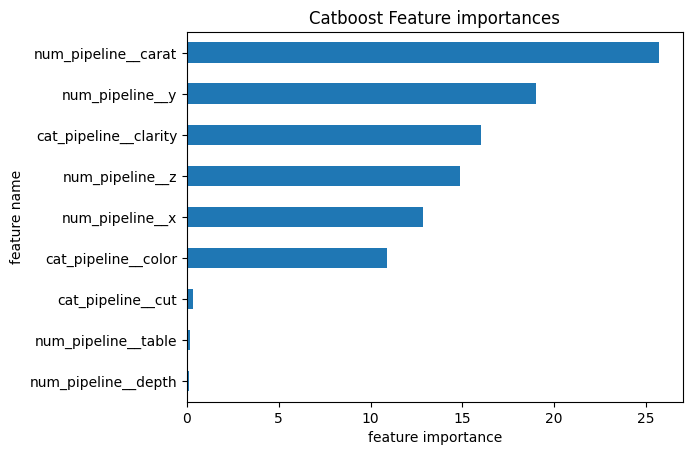

In [90]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')
plt.show()